In [2]:
import cv2 
import numpy as np
import cv2.aruco as aruco

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
!ls /dev | grep video

video2
video3


In [5]:
cam_id = 2
capture = cv2.VideoCapture(cam_id)

In [6]:
res = (1280, 720)
res_x, res_y = res
capture.set(3, res_x)
capture.set(4, res_y)
capture.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*"MJPG"))

True

In [7]:
from pathlib import Path

def get_path(path):
    path = Path(path)
    if not path.exists():
        return path
    raise ValueError("File Exists!")

In [8]:
import numpy as np
import time

TILE_SIZE = .2391 / 8
MARKER_SIZE = TILE_SIZE * 23 / 30


class Camera:

    def __init__(self, tile_size=TILE_SIZE, marker_size=MARKER_SIZE,
                 board_size=(5, 8),):
        self.captured_images = []

        self.dictionary = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
        self.parameters = aruco.DetectorParameters()
        self.charuco_params = aruco.CharucoParameters()

        self.tile_size = tile_size
        self.board = aruco.CharucoBoard(board_size, self.tile_size, marker_size,
                                        self.dictionary)
        self.board.setLegacyPattern(True)
        self.detector = aruco.CharucoDetector(
            self.board, self.charuco_params, self.parameters)

        self.mtx, self.dist = None, None
        self.captured_images = []
        self.last_time = 0

    def add_frame(self, image) -> np.ndarray:
        """
        returns RGBA array of size (x, y, 4)
        """
        image0 = image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        font = cv2.FONT_HERSHEY_SIMPLEX

        cur_corners, cur_ids, _ = self.detector.detectMarkers(image)

        if time.time() - self.last_time < 0.5:
            cv2.circle(image0, (1150, 700), 10, (255, 255, 0),
                       int(np.sin(time.time() - self.last_time) * 40) + 1)
        elif len(cur_corners) >= 19:
            cv2.circle(image0, (1200, 700), 10, (255, 255, 0), 2)
            self.captured_images.append(image0.copy())
            self.last_time = time.time()

        cv2.putText(image0, f"{len(cur_corners):02d}",
                    (64, 64), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
        return image0

    def load_coeffs(self):
        self.mtx = np.array([ 1.0687250840763766e+03, 0., 6.3526070691971165e+02, 0.,
       1.0737431805568067e+03, 3.5555335970090516e+02, 0., 0., 1. ]).reshape(3, 3)
        self.dist = np.array([[ -3.1759579767319194e-03, -2.0593634553884241e-01,
       -2.8115339213691912e-03, -3.8662066741185558e-03,
       2.4780625930115230e-01 ]])

        # self.mtx = np.array([[1.11297931e+03, 0.00000000e+00, 6.40000000e+02],
        #                      [0.00000000e+00, 1.11297931e+03, 3.60000000e+02],
        #                      [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
        # self.dist = np.zeros((1, 5))
        # ip-webcam, phone0
        # self.mtx = np.array([[1.00604718e+03, 0.00000000e+00, 6.35524500e+02],
        #                      [0.00000000e+00, 1.00242528e+03, 3.65893138e+02],
        #                      [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
        # self.dist = np.array(
        #     [[0.12490427, -0.38032263, -0.00073625, -0.00364679,  0.34870377]])

    def calibrate(self):
        matched_points = []
        for image in self.captured_images:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            cur_corners, cur_ids, *_ = self.detector.detectBoard(image)
            if cur_ids is not None:
                matched_points.append(list(
                    map(np.squeeze, self.board.matchImagePoints(
                        cur_corners, cur_ids.flatten()))
                ))
        obj_points, img_points = zip(*matched_points)
        print(obj_points[1].shape, len(img_points),
              obj_points[0].shape, img_points[0].shape)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
            obj_points, img_points, image.shape,
            None, None
        )
        self.mtx = mtx
        self.dist = dist
        print()
        print(self.mtx, self.dist)
        print()

    def process_charuko(self, frame):
        assert self.mtx is not None and self.dist is not None

        frame = frame.copy()

        font = cv2.FONT_HERSHEY_SIMPLEX
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        *_, corners, ids = self.detector.detectBoard(gray)

        if not len(corners):
            # cv2.putText(frame, "No Ids", (0,64), font, 1, (0,255,0),2,cv2.LINE_AA)
            return frame, None, None

        _, corners_checker, ids_checker = aruco.interpolateCornersCharuco(
            corners, ids,
            gray, self.board
        )

        _, rvec_check, tvec_check = aruco.estimatePoseCharucoBoard(
            corners_checker, ids_checker,
            self.board, self.mtx, self.dist,
            None, None
        )
        try:
            cv2.drawFrameAxes(frame, self.mtx, self.dist,
                              rvec_check, tvec_check, 0.1)
        except:
            pass
        # print(rvec_check, tvec_check)
        aruco.drawDetectedMarkers(frame, corners)
        rvecs, tvecs, _ = aruco.estimatePoseSingleMarkers(
            corners, self.tile_size / 2, self.mtx, self.dist)
        # print()
        # print(rvecs[0], tvecs[0])

        for rvec, tvec in zip(rvecs, tvecs):
            cv2.drawFrameAxes(frame, self.mtx, self.dist, rvec, tvec, 0.01)

        return frame, rvec_check, tvec_check

In [9]:

# with open("./data/images_1.npy", "rb") as f:
#     calibr.captured_images.extend(list(np.load(f)))
# with open("./data/images_2.npy", "rb") as f:
#     calibr.captured_images.extend(list(np.load(f)))

In [10]:
from websocket import create_connection
import json
def get_pos():
    req = {"command": "get_xyz", "args":[], "kwargs":{}}
    data = json.dumps(req)
    ws = create_connection("ws://localhost:9001")
    ws.send(data)
    res = json.loads(ws.recv())
    ws.close()
    return res

'572d80dd-9e72-4657-ba7a-b9f2a49221fa'

In [136]:
import pickle
end_effector_poses = []
cam_to_checkers = []
imgs = []
chars = []
raw_data = []


def append_data(xyz, rvec, tvec, img, char):
    raw_data.append(dict(xyz=xyz, rvec=rvec, tvec=tvec))
    end_effector_poses.append(get_ef(xyz))
    imgs.append(img)
    chars.append(char)
    cam_to_checkers.append(get_twist(cv2.Rodrigues(rvec)[0], tvec))
    with open("data_2.pickle", "wb") as f:
        pickle.dump(dict(raw_data=raw_data, cam_to_checkers=cam_to_checkers,
                         end_effector_poses=end_effector_poses,
                         imgs=imgs, chars=chars), f)

def get_ef(xyz):
    x, y, z = np.array(xyz) / 1000
    alpha = np.arctan2(y, x)
    matrix = np.array([[np.sin(alpha), 0, np.cos(alpha), x],
                       [-np.cos(alpha), 0, -np.sin(alpha), y],
                       [0, 1, 0, z],
                       [0, 0, 0, 1]])
    return matrix

def get_twist(R, p):
    return np.block([[R, p.reshape(-1, 1)], [0] * len(p) + [1]])

In [12]:
import sys
sys.path.insert(0, "..")
from eye_hand_calibration import get_board2base_transform

In [14]:
calibr = Camera(board_size=(5, 8))
calibr.load_coeffs()

In [19]:
from IPython.display import clear_output

cam_id = "http://192.168.43.1:8021/video"
capture = cv2.VideoCapture(cam_id)
calibr = Camera(board_size=(5, 8))
calibr.load_coeffs()

stream()
clear_output()

In [25]:
with get_path("0.npy").open("wb") as f:
    np.save(f, end_effector_poses)

In [24]:
from pathlib import Path

def get_path(path):
    path = Path(path)
    if not path.exists():
        return path
    raise ValueError("File Exists!")

In [ ]:
import matplotlib.pyplot as plt
_, cam_img = capture.read()
plt.imshow(cam_img)

In [27]:
get_pos()

{'result': [270.627197265625, -72.55900573730469, 65.44132995605469]}

In [93]:
def _stream():
    displaying_aruco = False
    while True:
        _, cam_img = capture.read()
        if not displaying_aruco:
            cv2.imshow('w', cam_img)
        else:
            cv2.imshow('w', calibr.process_charuko(cam_img.copy())[0])
        
        if (key := cv2.waitKey(1)) == ord("q"):
            break
        elif key == ord("n"):
            displaying_aruco = not displaying_aruco
        elif key in [ord("f"), ord("t")]:
            _, rvec, tvec = calibr.process_charuko(cam_img.copy())
            xyz = get_pos()["result"]
            print(xyz)
            append_data(xyz, rvec, tvec, cam_img, calibr.process_charuko(cam_img.copy())[0])
        clear_output(1)
        print(len(raw_data))
def stream():
    try:
        _stream()
    finally:
        cv2.destroyAllWindows()

In [139]:
stream()

7


Corrupt JPEG data: 4 extraneous bytes before marker 0xd5


In [143]:
with open("data_2.pickle", "rb") as f:
    data = pickle.load(f)
    raw_data = data["raw_data"]
    cam_to_checkers = data["cam_to_checkers"]
    chars = data["chars"]

end_effector_poses = []
for dat in raw_data:
    xyz = dat["xyz"]
    x, y, z = np.array(xyz) / 1000
    phi = np.arctan2(y, x)
    T = np.array([
        [np.cos(phi), np.sin(phi), 0, x],
        [np.sin(phi), -np.cos(phi), 0, y],
        [0, 0, -1, z],
        [0, 0, 0, 1],
    ])
    end_effector_poses.append(T)

In [150]:
get_B(cam_to_checkers[0], calc_normal(cam_to_checkers))

array([[ 0.88351759,  0.46821447, -0.06060719],
       [-0.4682213 ,  0.88360701,  0.0071037 ],
       [ 0.        ,  0.        ,  1.        ]])

In [152]:
cam_to_checkers

[array([[-0.88369808, -0.46799222, -0.00780915,  0.06193926],
        [ 0.46480942, -0.87940587,  0.10294427,  0.01807636],
        [-0.05504453,  0.08734189,  0.99465647,  0.25014895],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[-0.83656555, -0.54664738,  0.0365339 ,  0.10051929],
        [ 0.5469683 , -0.82951686,  0.11281606, -0.02035147],
        [-0.03136512,  0.11436091,  0.99294401,  0.18426017],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[-8.72974755e-01, -4.87765391e-01, -2.57482993e-05,
          8.32589857e-02],
        [ 4.85001112e-01, -8.68033015e-01,  1.06266676e-01,
          1.29091383e-02],
        [-5.18555573e-02,  9.27556378e-02,  9.94337665e-01,
          2.70410405e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[-0.89411546, -0.44760354, -0.01444379,  0.02658457],
        [ 0.44363273, -0.88967045,  0.10805785,  0.02417262],
        [-0.06121729,  0.0

In [147]:
chars[0].shape

(720, 1280, 3)

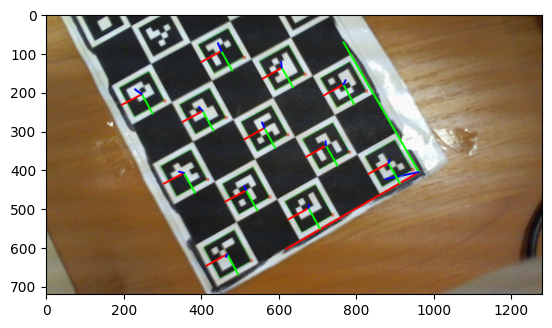

In [153]:
import matplotlib.pyplot as plt
plt.imshow(chars[2][:, :, [-1, 1, 0]])

In [141]:
t = get_board2base_transform(end_effector_poses, cam_to_checkers)
t

0.9999999999999999 0.9995207223418541
tsnei [-3.14111402  0.01057899 -0.04223592]


array([[-0.96783635, -0.25122416,  0.33147524],
       [-0.25125149,  0.96792177, -0.02793075],
       [ 0.        ,  0.        ,  1.        ]])

In [135]:
cam_to_checkers[0]

array([[-0.89862081, -0.43872111,  0.00210353,  0.00135843],
       [ 0.43623855, -0.89300547,  0.11062171,  0.0256333 ],
       [-0.04665362,  0.10032461,  0.99386036,  0.19457926],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [134]:
t = get_board2base_transform(end_effector_poses, cam_to_checkers)
np.linalg.inv(t) @ np.array([.045, .045, 1])

1.0 0.9998889488261827
tsnei [-3.13377405  0.00805668 -0.04592483]


array([0.2652634, 0.1471396, 1.       ])

In [105]:
np.array(get_pos()["result"]) / 1000

array([ 0.26742932, -0.0395747 , -0.06101032])